In [1]:
from vqa import *

In [2]:
# Define paths
train_img_dir = r"C:\Users\ved67\UIUC\CS521\CS521_HWs\hw5\VQA_Train\scene_img_abstract_v002_train2017"
train_img_prefix = "abstract_v002_train2015_"
train_question_json = r"C:\Users\ved67\UIUC\CS521\CS521_HWs\hw5\VQA_Train\OpenEnded_abstract_v002_train2017_questions.json"
train_answer_json = r"C:\Users\ved67\UIUC\CS521\CS521_HWs\hw5\VQA_Train\abstract_v002_train2017_annotations.json"

valid_img_dir = r"C:\Users\ved67\UIUC\CS521\CS521_HWs\hw5\VQA_Valid\scene_img_abstract_v002_val2017"
valid_img_prefix = "abstract_v002_val2015_"
valid_question_json = r"C:\Users\ved67\UIUC\CS521\CS521_HWs\hw5\VQA_Valid\OpenEnded_abstract_v002_val2017_questions.json"
valid_answer_json = r"C:\Users\ved67\UIUC\CS521\CS521_HWs\hw5\VQA_Valid\abstract_v002_val2017_annotations.json"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = SimpleTokenizer(max_len=50)
train_dataset = VQADataset(train_img_dir, train_img_prefix, train_question_json, train_answer_json, transform, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = VQADataset(valid_img_dir, valid_img_prefix, valid_question_json, valid_answer_json, transform, tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

vocab_size = len(tokenizer.idx2token)
model = VQAModel(vocab_size=vocab_size, embedding_dim=50, hidden_size=256).to(device)

Using cache found in C:\Users\ved67/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ved67\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs=5, tokenizer=tokenizer)

Epoch 1/5, Loss: 0.2474
Validation Loss: 0.1566
Predicted: yes, Pred Tokens: [[1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [17, 18, 2, 2, 2], [17, 18, 2, 2, 2], [17, 18, 2, 2, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2], [1, 28, 8, 22, 2]]
Sample Q: does the sidewalk suddenly disappear?
GT Answer: yes
Predicted: yes
Accuracy: 0.4985
Correct 5332, Total: 10696
Epoch 2/5, Loss: 0.1563
Validation Loss: 0.1588
Predicted: no, Pred Tokens: [[1, 17, 18, 2], [1, 17, 18, 2], [1, 17, 18, 2], [17, 18, 2, 2], [1, 17, 18, 2], [17, 18, 2, 2], [17, 18, 2, 2], [1,

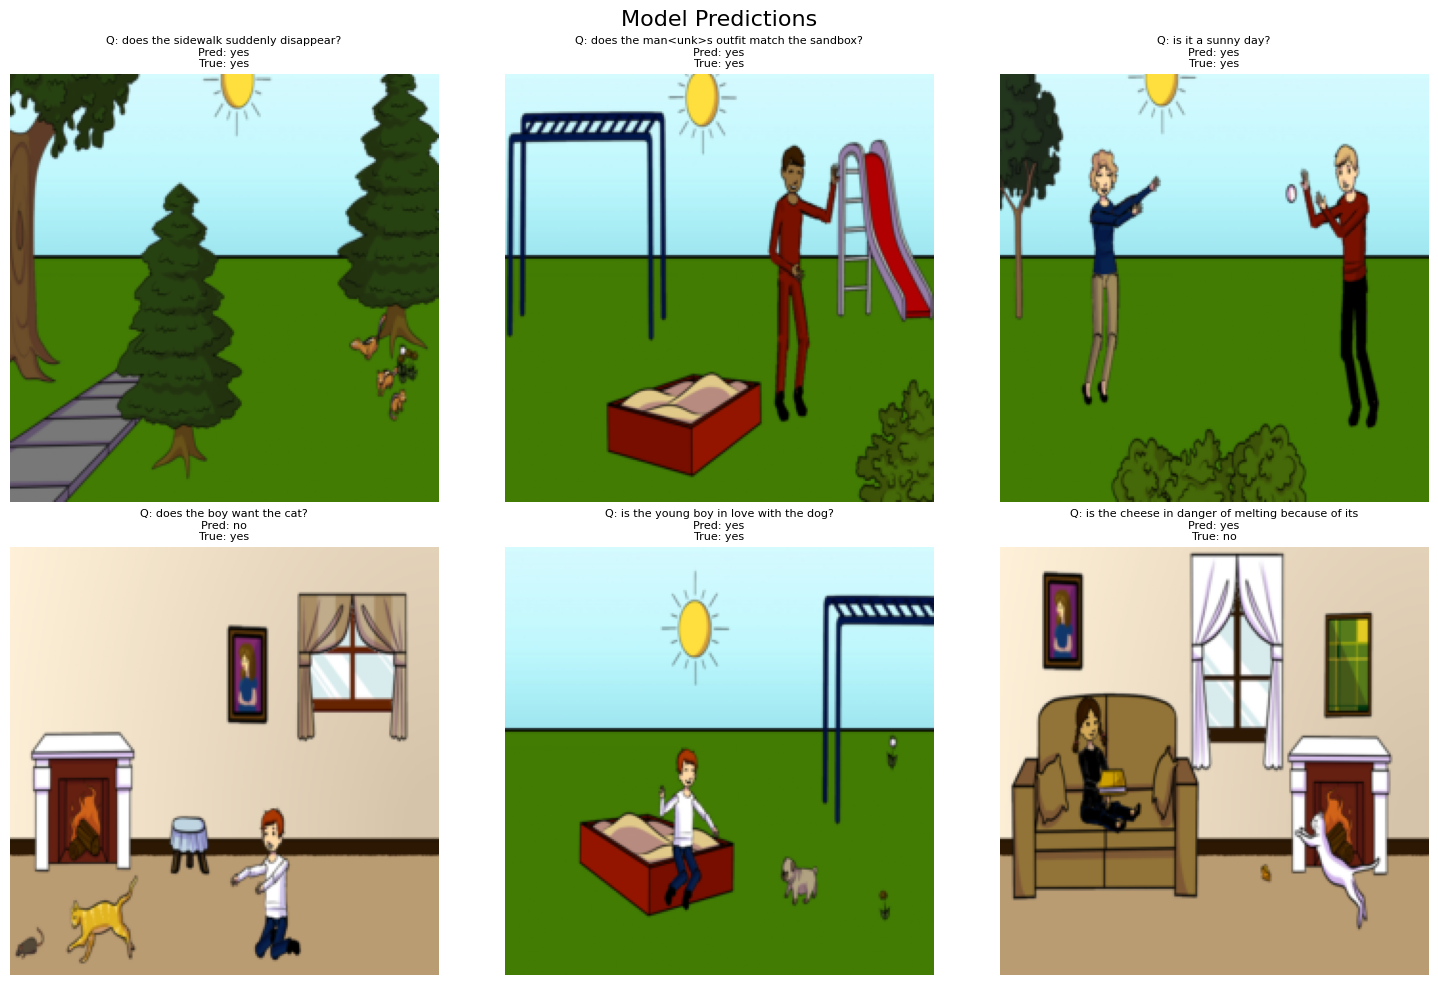

In [31]:
import matplotlib.pyplot as plt

def show_predictions(model, dataset, num_samples=6):
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Predictions', fontsize=16)
    
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            row = i // 3
            col = i % 3
            image, question, answer = dataset[i]
            image_input = image.unsqueeze(0).to(device)
            question_input = question.unsqueeze(0).to(device)
            answer_input = answer.unsqueeze(0).to(device)
            
            predicted_tokens, _ = model(image_input, question_input, None, 
                                     teacher_forcing=False, max_len=10)
            pred_answer = tokenizer.decode(predicted_tokens[0])
            true_answer = tokenizer.decode(answer)
            question_text = tokenizer.decode(question)
            image = image.cpu()
            image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            image = image.permute(1, 2, 0).numpy()
            axes[row, col].imshow(image)
            axes[row, col].axis('off')
            axes[row, col].set_title(f'Q: {question_text}\nPred: {pred_answer}\nTrue: {true_answer}',
                                   fontsize=8, wrap=True)
    plt.tight_layout()
    plt.show()

show_predictions(model, valid_dataset)